In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.distributions import LogNormal

In [65]:
device = torch.device("cpu")

def shock_draw(n, sigma):
    return torch.exp(torch.normal(0, sigma, size=(n, 1), dtype=torch.float64))

# Utility function
def utilities(parm, n, sig, rho, valuefunction):
    beta    =  parm[0]
    alpha   =  parm[1]
    delta   =  parm[2]
    
    k_max   =  3
    k_min   =  0.1 + 1e-4
    k       =  ((k_max - k_min) * torch.rand(n, 1, dtype=torch.float64) + k_min).to(device)
    k.requires_grad_(True)
    
    sk_now  =  shock_draw(n, sig / np.sqrt(1 - rho**2))
    sk_nxt1 =  shock_draw(n, sig / np.sqrt(1 - rho**2))
    sk_nxt2 =  shock_draw(n, sig / np.sqrt(1 - rho**2))

    V = valuefunction(torch.cat((k, sk_now), dim=1))
    V.backward(torch.ones_like(V), retain_graph=True)
    kgrad  =  k.grad

    k_p    =  sk_now * k**alpha - sk_now * alpha * k**(alpha - 1) / kgrad

    c      =  sk_now * k ** alpha + (1 - delta) * k - k_p
    c[c < 0] = 1e-11
    c      =  torch.log(c).to(device)
    return k, k_p, c, sk_now, sk_nxt1, sk_nxt2

The whole code is set to run on a CPU.

The main part of this cell is to generate capital states, capital choice, utility and shocks. Where productivity is $\exp(z)$ and $z\sim\mathcal{N}\left(0,{\sigma}/{\sqrt{1 - \rho^2}}\right)$.

To extract the gradient of NNs-based $V(k,z)$ with respect to $k$ (variable 'kgrad' in code), I perform the backpropagation and capital choice is given by
$$k_p  = z k^\alpha - \frac{z\alpha k^{\alpha-1}}{kgrad}$$

In [66]:
# Neural Networks with He Initialization
n1 = 64
valuefunction = nn.Sequential(nn.Linear(2, n1).double(),
                              nn.ReLU().double(),
                              nn.Linear(n1, 1).double())

# Apply He initialization to the layers
for layer in valuefunction:
    if isinstance(layer, nn.Linear):
        nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
        
valuefunction = valuefunction.to(device)

In [67]:
losses = []

# Optimization
def optimization_with_early_stopping(parm, n, learning_rate, betas, wdecay, iten):
    beta   =  parm[0]
    alpha  =  parm[1]
    delta  =  parm[2]
    
    optimizer = torch.optim.Adam(valuefunction.parameters(), lr=learning_rate)
    num_epochs = iten
    Floss     = torch.empty(num_epochs)
    for epoch in range(num_epochs):
        k, k_p, U, sk_now, sk_nxt1, sk_nxt2  =  utilities(parm, n, 0.1, 0.8, valuefunction)
        V    =  valuefunction(torch.cat((k, sk_now), dim=1))
        V_1  =  valuefunction(torch.cat((k_p, sk_nxt1), dim=1))
        V_2  =  valuefunction(torch.cat((k_p, sk_nxt2), dim=1))

        optimizer.zero_grad()

        loss1  =  V - U - beta * V_1
        loss2  =  V - U - beta * V_2

        loss = 0.5 * torch.mean(torch.abs(loss1 * loss2)) 

        loss.mean().backward(retain_graph=True)
        Floss[epoch]  =  torch.max(loss)
        losses.append(loss.item())
        
        # if torch.max(loss) < 1e-5:
        #     print(f"Early stopping at epoch {epoch}")
        #     break

        optimizer.step()
        
        k.grad.zero_()

        if epoch % 100 == 0:
            print(f"Iteration {epoch}, Loss: {loss.item()}")

    return Floss[:epoch+1]

In [68]:
# Parameters and hyperparameters
n = 50
beta = 0.95 
alpha = 0.36
delta = 1
learning_rate = 1e-3
betas         = (0.9, 0.99)
wdecay        = 0
iten          = 10000

loss  =  optimization_with_early_stopping([beta, alpha, delta], n, learning_rate, betas, wdecay, iten)

# Calculate NNs-based value function
k     =  np.linspace(0.1 + 1e-4, 3, 100)[:, None]
kten  =  torch.tensor(k, dtype=torch.float64).to(device)
plot  =  torch.cat((kten, torch.ones((100, 1), dtype=torch.float64).to(device)), dim=1)
knn   =  valuefunction(plot).cpu().detach().numpy()

# Calculate analytical value function
M   = (np.log(1 - alpha * beta) + alpha * beta * np.log(alpha * beta) / (1 - alpha * beta)) / (1 - beta)
N   = alpha / (1 - alpha * beta)
kan = M + N * np.log(k)

Iteration 0, Loss: 204.05058472628298
Iteration 100, Loss: 0.148018155813909
Iteration 200, Loss: 0.1067000380777573
Iteration 300, Loss: 0.11918900104117404
Iteration 400, Loss: 136.9803655325908
Iteration 500, Loss: 149.28096619800388
Iteration 600, Loss: 0.09735660719078179
Iteration 700, Loss: 0.08014151264241211
Iteration 800, Loss: 0.14866458772565508
Iteration 900, Loss: 0.09047758287995583
Iteration 1000, Loss: 0.1884964178273796
Iteration 1100, Loss: 0.48709033786438755
Iteration 1200, Loss: 0.2653709881290338
Iteration 1300, Loss: 0.2848314425678569
Iteration 1400, Loss: 0.3156281685250337
Iteration 1500, Loss: 0.3047572599499269
Iteration 1600, Loss: 0.2862281640989288
Iteration 1700, Loss: 0.28262378857259507
Iteration 1800, Loss: 0.2342492059920165
Iteration 1900, Loss: 0.23025581099548767
Iteration 2000, Loss: 0.2697791271543036
Iteration 2100, Loss: 0.7749530164223768
Iteration 2200, Loss: 0.2807262478748397
Iteration 2300, Loss: 0.11726403100660582
Iteration 2400, Loss:

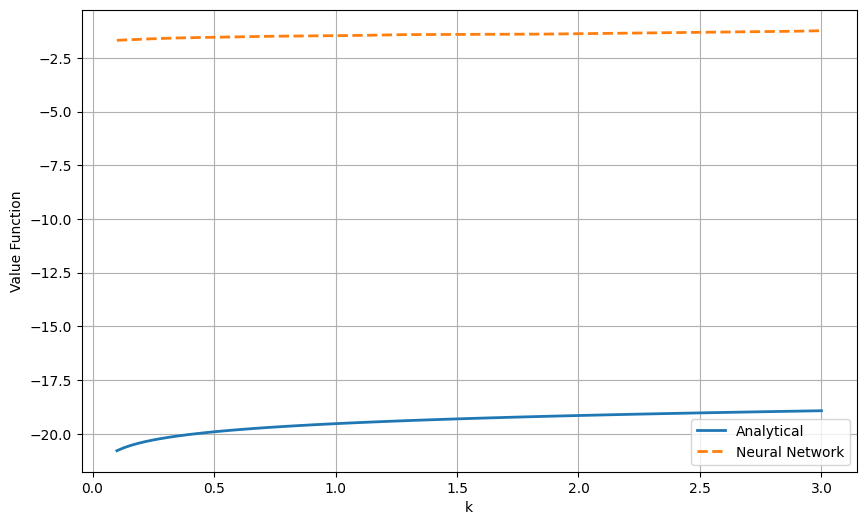

In [69]:
plt.figure(figsize=(10, 6))
plt.plot(k, kan, label='Analytical', linewidth=2)
plt.plot(k, knn, label='Neural Network', linestyle='--', linewidth=2)
plt.xlabel('k')
plt.ylabel('Value Function')
plt.legend()
plt.grid(True)
plt.show()

0.00259784885921


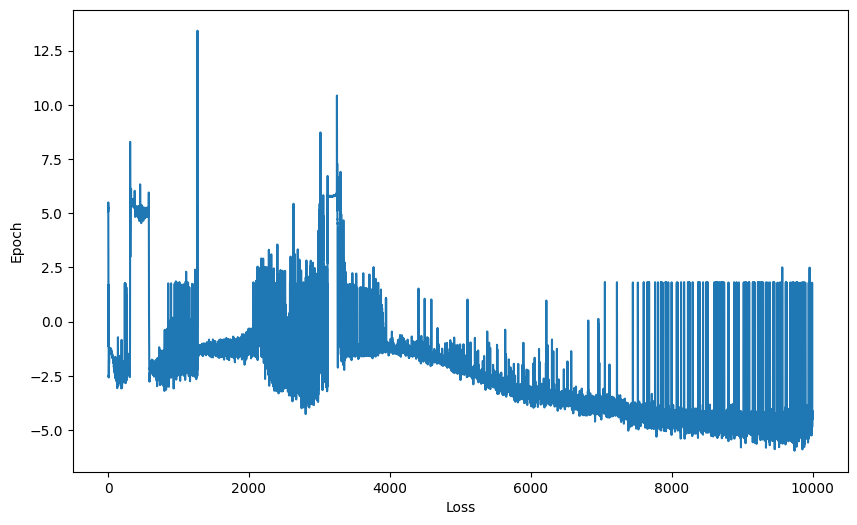

In [70]:
plt.figure(figsize=(10, 6))

plt.plot(np.log(losses))
plt.xlabel('Loss')
plt.ylabel('Epoch')
print(np.min(losses))